### Code for Project 2: "Synthesis of control policies from demonstrations for fully driverless trains"

The setup is as follows: we want to synthesize a policy for a driverless train from expert demonstration data.

The goal is to find a control policy that makes the behavior of the controlled train similar to the one of the demonstrations, i.e. the experts.

The code below provides all the necessary probability functions that you need to successfully complete the tasks.

In [111]:
import json
import math

import numpy as np
import scipy.stats as stats

from scipy import interpolate
from scipy.interpolate import interpolate
from scipy.interpolate import CubicSpline 

from matplotlib import pyplot as plt

$\textbf{Kullback-Leibler divergence}$ 

The general form of Kullback-Leibler divergence is:

$$\mathcal{D}_{KL}(f(x)||g(x)) = \int f(x) \ln{\frac{f(x)}{g(x)} dx}$$

In the case of a normal distribution the Kullback-Leibler divergence becomes:
$$\mathcal{D}_{KL}(f(x)||g(x)) = \ln{\left(\frac{\sigma_2}{\sigma_1}\right)} + \frac{\sigma_1^2}{2\sigma_2^2} + \frac{(\mu_1 - \mu_2)^2}{\sigma_2^2}- \frac{1}{2}$$
In the following function DKL is calculated between two Gaussian, coded as an array of [mean, std].


In [112]:
def DKL_gaussians(g1,g2):
    mu1 = g1[0] #Extracting means
    mu2 = g2[0]
    sigma1 = g1[1] #Extracting stds
    sigma2 = g2[1]
    
    el1 = math.log(sigma1/sigma2) #Calculating the sub-elements of the formula
    el2 = sigma1*sigma1 + (mu1-mu2)*(mu1-mu2)
    el3 = 2*sigma2*sigma2
    
    return(el1 + el2/el3 - 0.5)

$\textbf{Parameters for} \, f(x_k|x_{k-1}, u_k) \, \text{ and } \, g(x_k|x_{k-1}, u_k)$

In [113]:
#Parameters for f(x_k|x_{k-1},u_k)
a_c = 0.982
b_c = 0.2591
sigma_c = 13.059

#Parameters for g(x_k|x_{k-1},u_k)
a_e = 0.9811
b_e = 0.2723
sigma_e = 8.811

#Bounds for u (velocity) and x (distance)
v_min = 15
v_max = 85
d_min = 0
d_max = 1500

#Amount of bins (resolution) for u and x
v_discr = 100
d_discr = 100

$\textbf{Discretization step and axis preparation}$

From all possible states and control input values, from a minimum value to a max value, we sampled $d\_discr$ samples. The discretization step is obtained as:
\begin{equation*}
    d\_step = \frac{max - min}{d\_discr}
\end{equation*}
Then we compute the horizontal axis taking into account the mean value in each d_step.

In [114]:
d_step = (d_max-d_min)/d_discr # Discretization step for x
v_step = (v_max-v_min)/v_discr # Discretization step for u

x_axis = [d_min + (i+0.5)*d_step for i in range(d_discr)]
u_axis = [v_min + (j+0.5)*v_step for j in range(v_discr)]


$\textbf{TASK 1: give a detailed documentation of what this function does and how it fits in the methodology}$

The following function gets the probability mass function of the plant:
\begin{equation*}
    f(x_k|x_{k-1}, u_k), \quad g(x_k|x_{k-1}, u_k)
\end{equation*}

The function parameters $a, b$ represent the linear parameters for the mean, while the function parameter $\sigma$ represents the standard deviation of the pmf.

In particular the mean is obtained as: $$\mu = ax_{k-1} + bu_k$$ For each combination $(x_{k-1}, u_k)$ the pair $[\mu, \sigma]$ is stored in the matrix $res$.

In [115]:
def getPlant(a, b, sigma):
    # Function for getting the plant (f_x or g_x) from the parameters.
    # The arguments are the linear parameters for the mean and the std.
    # The Gaussians are simply coded as [mean, std] to simplify calculations
    res = np.zeros((d_discr,v_discr,2)) # Initializing the empty array
    for i in range(d_discr): # Iterating over the state space for x_{k-1}
        x_km1 = d_min + (i+0.5)*d_step # Calculating x_{k-1}
        for j in range(v_discr): # Iterating over the action space for u_k
            u_k = v_min + (j+0.5)*v_step  # Calculating u_k
            mu = a*x_km1 + b*u_k # Calculating the average of the Gaussian
            res[i][j] = [mu, sigma] # Adding the Gaussian in [mean, std] form to the array
    return(res)

$\textbf{TASK 2: plot the probability functions used in the example}$
 
$\textbf{(below you have the parameters and recall the functions are Gaussians)}$

Through the function $getPlant$ we obtain $f(x_k|x_{k-1}, u_k)$ which is the autonomous train plant and $g(x_k|x_{k-1}, u_k)$ the expert train plant.

Using the lib $stats$ we plot the Gaussian with a specific $[\mu, \sigma]$ obtained by the train plant and the expert plant.


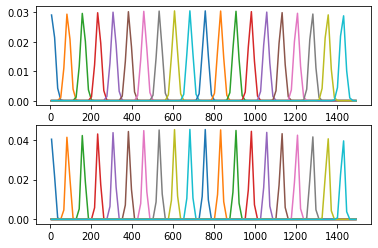

In [116]:
# f(x_k|x_{k-1}, u_k)
f_x = getPlant(a_c, b_c, sigma_c)

# g(x_k|x_{k-1},u_k)
g_x = getPlant(a_e, b_e, sigma_e)


for i in range(0, f_x.shape[1] - 1, 5):
    plt.subplot(2,1,1)
    plt.plot(x_axis, stats.norm.pdf(x_axis, f_x[i][i+1][0], f_x[i][i+1][1])) #f_x[xkm1][uk][0] = μ, f_x[xkm1][uk][1]= σ
    plt.subplot(2,1,2)
    plt.plot(x_axis, stats.norm.pdf(x_axis, g_x[i][i+1][0], g_x[i][i+1][1])) #g_x[xkm1][uk][0] = μ, g_x[xkm1][uk][1]= σ
    

With the following code we want to demonstrate that in a given state (e.g. state=98) it is more likely to go back instead of going forward.

We have used a table to represent what are the states that we can reach starting from the current state (column "Index"), what is the range of meters encoded with the same index state (column "Range meters") and how many control inputs allow to reach it (column "Number of occurrences").

In this way, we have demonstrated why our system can't reach the final destination.

In [117]:
from prettytable import PrettyTable 

state = 98
header = ['Index', 'Range meters', 'Number occurrences']

table = PrettyTable(header)
mydict = {}

for i in range(v_discr):
    index = str(round(f_x[state][i][0]/d_step))
    if index not in mydict:
        mydict[index] = []
    mydict[index].append('%.3f'%(f_x[state][i][0]))

for i in mydict.keys():
    x = len(mydict[i])
    if x != 0: 
        mydict[i] = "["+str(mydict[i][0]) +", " +str(mydict[i][-1])+"]"
        table.add_row([i, mydict[i],x])
    
print(table)


+-------+----------------------+--------------------+
| Index |     Range meters     | Number occurrences |
+-------+----------------------+--------------------+
|   97  | [1454.882, 1462.500] |         43         |
|   98  | [1462.681, 1472.838] |         57         |
+-------+----------------------+--------------------+


$\textbf{TASK3: find out why this function is needed}$

$means["x"]$ and $means["y"]$ are arrays of values used to approximate some function $g(u_k|x_{k-1})$. 

The interpolation operation is needed to define a function to identify new points of a discrete set from the dataset. 

In [118]:
# Data sources
f1 = open('train_mean.json')
f2 = open('train_std.json')

means = json.load(f1)
std = json.load(f2)

# We approximate the mean function using the arrays means['x'] and means['y'].
fmean = interpolate.interp1d(means['x'],means['y'], fill_value="extrapolate")

# We approximate the std function using the arrays std['x'] and std['y'].
fstd = interpolate.interp1d(std['x'],std['y'], fill_value="extrapolate")

#We call the function fmean, passing as a parameter the array x_axis, to calculate the value of new points.
example_means = fmean(x_axis)
#We call the function fstd, passing as a parameter the array x_axis, to calculate the value of new points.  
example_std = fstd(x_axis)

$\textbf{TASK4: plot sample trajectories from the files below. What is the train doing?}$

We plot the trajectory of the expert $g(u_k|x_{k-1})$, showing also the variance around the mean value of the trajectory. We call the function fmean, passing as a parameter the array $x\_axis$, to calculate the value of new points.
The simulation starts with the train in motion.
From the plot we observed that the train is decreasing its speed.

In addition, we have used a different interpolation, but the result is the same.

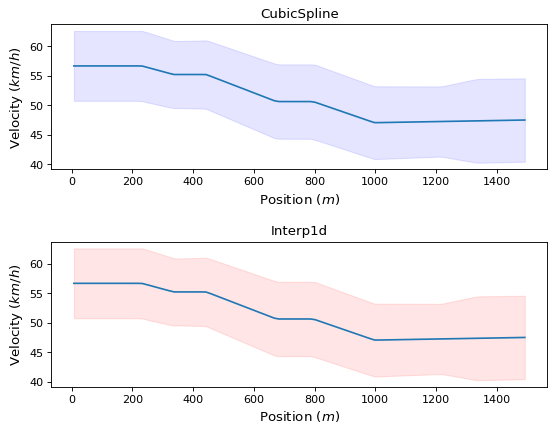

In [119]:
#Another way to do the interpolation
fmean_c = CubicSpline(means['x'],means['y'])
fstd_c = CubicSpline(std['x'],std['y'])

example_means_c = fmean_c(x_axis)
example_std_c = fstd_c(x_axis)

#Plot with CubicSpline
plt.figure(figsize=(8, 6), dpi=80)
plt.subplots_adjust(hspace=.5 )
plt.subplot(2, 1, 1)
plt.title("CubicSpline")
plt.plot(x_axis, example_means_c)
plt.xlabel(r'Position $(m)$', fontsize=12)
plt.ylabel(r'Velocity $(km/h)$', fontsize=12)
plt.fill_between(x_axis, example_means_c - example_std_c, example_means_c + example_std_c, color='b', alpha = 0.1)

#Plot with Interp1d
plt.subplot(2, 1, 2)
plt.title("Interp1d")
plt.plot(x_axis, example_means)
plt.xlabel(r'Position $(m)$', fontsize=12)
plt.ylabel(r'Velocity $(km/h)$', fontsize=12)
plt.fill_between(x_axis, example_means - example_std, example_means + example_std, color='r', alpha = 0.1)

This function samples from a Gaussian with specified parameters

In [120]:
def sample_gaussian(mu, sigma, Ax):
    #where Ax is the horizontal axis
    pmf = [0]*len(Ax) #Initializing the pmf
    for i in range(len(Ax)): #Iterating over the state space to calculate the elements of the pmf
        pmf[i] = np.exp(-0.5*((Ax[i]-mu)/sigma)**2) #Using the explicit formula for the Gaussian
                                            #The multiplicative factor is omitted as the pmf will be normalized
    S = np.sum(pmf) #Calculating the sum for normalization
    return([x/S for x in pmf])

This function is used to return the target policy given a state.

In [121]:
def ex_policy(x_km1):
    indX = int(x_km1//d_step) #Calculating the index to which corresponds x_km1
    return(sample_gaussian(example_means[indX],example_std[indX],u_axis))

This function is used to return the target policy given a index.

In [122]:
def target_policy(indX):
    #Returns the target policy for the state index indX
    return(sample_gaussian(example_means[indX],example_std[indX],u_axis))


$\textbf{TASK 5: write down the formal problem statement for the control problem considered within this project}$

Assuming to know pdf $f(x_k|x_{k-1}, u_k)$ and have available $\textit{demonstration dataset }$ $\Delta^e_{0:N}$ the goal is to synthesize, from such dataset, a control policy that could be used by the agent to solve the same task as the one being demonstrated.
It is formally intended that the agent has to behave like the demostrator. As we have already seen, we can have the following probabilistic description:

$$g(\Delta^e_{0:N}) = g(x_0)\prod_{k=1}^N g(x_k, u_k|x_{k-1}) = g(x_0)\prod_{k=1}^N g(x_k| u_k, x_{k-1})g(u_k|x_{k-1})$$
The problem of synthesizing control policies that make the behavior of the system similar to the behavior seen in the demonstration dataset can be formalized as the following decision-making problem:


$\textit{Find the policy}$ $\{f_{k|k-1}^{(u), *}\}_{1:N}$ $\textit{such that:}$

$$\{f_{k|k-1}^{(u), *}\}_{1:N} \in \arg\min_{ \{f_{k|k-1}^{(u)}\}_{1:N}} \mathcal{D}_{KL}(f_{0:N}||g_{0:N})$$
$$s.t. \quad f^{(u)}_{k|k-1} \in \mathcal{D}, \forall k \in 1:N$$
Minimizing $\mathcal{D}_{KL}(f_{0:N}||g_{0:N})$ means making $f_{0:N}$ as similar as possible to $g_{0:N}$.

The optimal policy which resolve the problem is given, at each time step $k$ from:
$$f^{(u),*}_{k|k-1} =  g^{(u)}_{k|k-1} \dfrac{exp\left(-\mathcal{D}_{KL}(f^{(x)}_{k+1|k}||g^{(x)}_{k+1|k})+ \mathbb{E}_{f^{(x)}_{k+1|k}}[\gamma_k(X_k)]\right)}{\int g^{(x)}_{k+1|k} exp\left(-\mathcal{D}_{KL}(f^{(x)}_{k+1|k}||g^{(x)}_{k+1|k})+ \mathbb{E}_{f^{(x)}_{k+1|k}}[\gamma_k(X_k)]\right) du_k}$$

in which $\gamma_k$ is obtained by a $\textbf{backward recursion}$:
$$ \gamma_k(x_k) = \ln{\mathbb{E}_{g^{(u)}_{k+1|k}} [exp(-\mathcal{D}_{KL}(f^{(x)}_{k+1|k}||g^{(x)}_{k+1|k})]}$$

$\textbf{TASK 6: write here the code to solve the control problem (greedy version)}$

We have implemented runFPD function for implementing the algorithm for control from demonstrations. In addition, it is included the receding horizon version of the algorithm.

In [123]:
def runFPD(xStart, tHor=0):
    #Runs the control from demos algorithm, assuming the agent is at state xStart (given as an index!) with a time horizon tHor
    #Initializing zero gamma function
    gamma = np.zeros(d_discr)
    # If time horizon is greater than 0 we consider the states from the min between (xStart + time horizon -1) and 
    # (d_discr-1) (in order to not exceed the dimension of the array) to (xStart + 1) 
    if tHor > 0: 
        stateAtTime = list(range(min(xStart + tHor-1, d_discr - 2), xStart + 1, -1)) # remember xStart = xkm1
    # Else we don't take into account the future states, but we consider only the next time step
    else: 
        stateAtTime = [] 
    
    # We calculate gamma from (xStart + time horizon -1) to (xStart + 1)
    for xk, uk in zip(stateAtTime, stateAtTime):
        # We initialize an auxiliary array, which we will use to calculate gamma_k(x_k) 
        gammaArray = np.zeros(v_discr)
        # We get f(x_{k+1}|x_k,u_{k+1}) in [mean, std] form
        plant = f_x[xk][uk+1] 
        # We get g(x_{k+1}|x_k,u_{k+1}) in [mean, std] form
        target_plant = g_x[xk][uk+1]
         # We build the array with the exp of the DKL of the 'future' plants
        gammaArray[uk+1] = np.exp(-DKL_gaussians(plant, target_plant))
        # Finally we calculate gamma, which is the log of the expectation of our auxiliary array
        gamma[xk] = np.log(np.dot(target_policy(xk),gammaArray)) 
    
    #previous state x_(k-1)
    xkm1 = xStart  
    policy = np.zeros(v_discr)
    # We extract the corresponding target policy, g(u_k|x_{k-1}) 
    target_pol = target_policy(xkm1) 
    for u in range(v_discr): 
        # We get f(x_{k}|x_{k - 1}, u_k) 
        plant = f_x[xkm1][u] 
        # We get g(x_{k}|x_{k - 1}, u_k) 
        target_plant = g_x[xkm1][u]
        # We sample plant for expectations
        plant_sampled = sample_gaussian(plant[0],plant[1],x_axis) 
        policy[u] = target_pol[u]*np.exp(-DKL_gaussians(plant, target_plant) + np.dot(plant_sampled,gamma))
    # We calculate the integral
    S = np.sum(policy)
    # We return the normalized result 
    return([elt/S for elt in policy]) 

$\textbf{TASK 7: Write a routine to validate your code}$

To validate our code we have written a simulation of the closed loop system starting from the initial state.

Speed: 59.099999999999994 km/h
New position: 23.86388053752801 m
Speed: 50.699999999999996 km/h
New position: 50.43264330930543 m
Speed: 58.4 km/h
New position: 66.72648142177722 m
Speed: 63.3 km/h
New position: 81.68009038012923 m
Speed: 63.3 km/h
New position: 91.52691332071414 m
Speed: 57.0 km/h
New position: 105.9308228360363 m
Speed: 55.599999999999994 km/h
New position: 152.15012239946645 m
Speed: 61.199999999999996 km/h
New position: 158.4203742162655 m
Speed: 59.099999999999994 km/h
New position: 174.26287735264503 m
Speed: 43.7 km/h
New position: 189.74120760140556 m
Speed: 66.8 km/h
New position: 205.10627106576453 m
Speed: 52.8 km/h
New position: 226.5086055202787 m
Speed: 45.099999999999994 km/h
New position: 224.90788825746904 m
Speed: 52.8 km/h
New position: 239.37146458051657 m
Speed: 53.5 km/h
New position: 236.32687002000023 m
Speed: 50.699999999999996 km/h
New position: 278.1554212927268 m
Speed: 50.0 km/h
New position: 304.1588548553335 m
Speed: 57.699999999999996 km

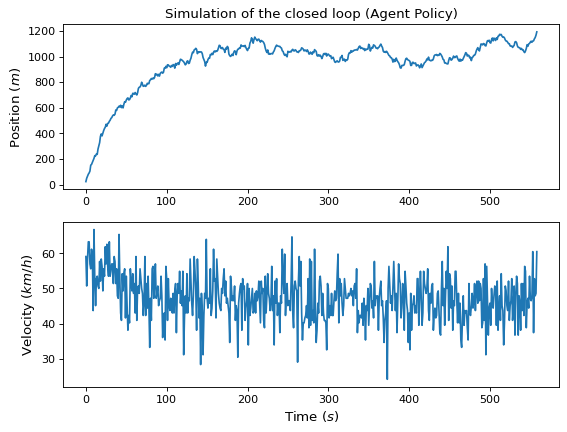

In [124]:
def simulation():

    position = []
    speed = []
    x = 0

    while(x < d_discr - 20): #half-way termination condition
        policy = runFPD(x) # We get the optimal policy
        u = np.random.choice(range(v_discr),p=policy) # We choose a random index u from the policy according to the distribution of it.
        plant = f_x[x][u] # We get the mean and the standard deviation of the next state given the actual state and the current input.
        # We get the new state from the Gaussian plant
        trueX = np.random.normal(plant[0],plant[1])
        # We compute the state index and verify if it is inside the range [0, d_discr - 1]
        x = round((trueX-d_min)/d_step)
        
        x = max(x, 0)
        
        # We compute the value of input from the input index
        trueU = v_min + v_step*u
        
        position.append(trueX)
        speed.append(trueU)

        print("Speed: " + str(trueU) + " km/h")
        print("New position: " + str(trueX) + " m")

    plt.figure(figsize=(8, 6), dpi=80)
    plt.subplot(2,1,1)
    plt.title("Simulation of the closed loop (Agent Policy)")
    plt.ylabel(r'Position $(m)$', fontsize=12)
    plt.plot(position)
    
    plt.subplot(2,1,2)
    plt.xlabel(r'Time $(s)$', fontsize=12)
    plt.ylabel(r'Velocity $(km/h)$', fontsize=12)
    plt.plot(speed)
    plt.show()

simulation()

$\textbf{TASK 8: evaluate how the computation times change depending on the discretization}$

We have seen that the computational effort increases with the decreasing of the
discretization step or, likewise, the increasing in the number of samples.